In [31]:
!pip install transformers keras jax tensorflow

In [32]:
import os

os.environ["KERAS_BACKEND"] = "tensorflow"

import keras
from keras import layers, ops

from sklearn.model_selection import train_test_split

from ast import literal_eval
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np

In [33]:
data_dir = "./data"
df_data = pd.read_csv("./data/train_new.csv", sep=",")
df_data.drop(columns=["main_photo", "is_markup", "target", "stratify_column"], axis=1, inplace=True)
df_test = pd.read_csv("./data/test.csv", sep=",")
df_test.drop(columns=["main_photo", "is_markup", "target", "stratify_column"], axis=1, inplace=True)
df_data.head()

,name,type,category_l2,category_l4,__index_level_0__,Unnamed: 9,Unnamed: 10
0,"Угольник-переходник ROMMER ВПр-НР, 15х1_2, из ...",Удлинитель.сантехнический,Строительство и ремонт,Фитинг сантехнический,446046,NaN,NaN
1,"Ножницы Волна , 9"", 23 см, шаг - 18 мм, цвет ч...",Пирог,Хобби и творчество,Набор для шитья одежды,50527,NaN,NaN
2,"15 шт. Мелки школьные Гамма, цветные, 10шт., м...",Проживание.в.пансионате,Канцелярские товары,Мелки,558059,NaN,NaN
3,Бра LED,Подсветка.для.картин,Строительство и ремонт,Настенный светильник,52215,NaN,NaN
4,Накидки-квадраты для Ауди с3 (2006 - 2008) хэт...,Спинка.автомобильного.сиденья,Автотовары,Накидка на сиденье,309604,NaN,NaN


In [34]:
print(f"There are {len(df_data)} rows in the dataset.")

There are 140 rows in the dataset.


In [35]:
total_duplicate_names = sum(df_data["type"].duplicated())
print(f"There are {total_duplicate_names} duplicate types.")

There are 16 duplicate types.


In [36]:
df_data = df_data[~df_data["type"].duplicated()]
print(f"There are {len(df_data)} rows in the deduplicated dataset.")

print(sum(df_data["type"].value_counts() == 1))

print(df_data["type"].nunique())

There are 124 rows in the deduplicated dataset.
124
124


In [37]:
train_df = df_data
test_df = df_test
val_df = test_df.sample(frac=0.5)
test_df.drop(val_df.index, inplace=True)

print(f"Number of rows in training set: {len(train_df)}")
print(f"Number of rows in validation set: {len(val_df)}")
print(f"Number of rows in test set: {len(test_df)}")

Number of rows in training set: 124
Number of rows in validation set: 250
Number of rows in test set: 250


## Multi-label binarization

In [38]:
import tensorflow as tf

types = tf.ragged.constant(train_df["type"].values)
lookup = layers.StringLookup(output_mode="one_hot")
lookup.adapt(types)
vocab = lookup.get_vocabulary()


def invert_multi_hot(encoded_labels):
    """Reverse a single multi-hot encoded label to a tuple of vocab terms."""
    hot_indices = np.argwhere(encoded_labels == 1.0)[..., 0]
    return np.take(vocab, hot_indices)


print("Vocabulary:\n")
print(vocab)


Vocabulary:

['[UNK]', np.str_('Юбка.карнавальная'), np.str_('Электрокуртка'), np.str_('Шлем.для.картинга'), np.str_('Ширма'), np.str_('Чехол.для.плеера'), np.str_('Хлопья.для.животных'), np.str_('Фунгицид'), np.str_('Фотоадаптер.для.телескопа'), np.str_('Услуги.по.поиску.работы'), np.str_('Услуги.по.подбору.персонала'), np.str_('Усилитель.бампера'), np.str_('Удлинитель.сантехнический'), np.str_('Удлинитель.инструмента'), np.str_('Туалетный.столик'), np.str_('Тренировочные.перчатки.для.футбола'), np.str_('Точильный.камень.для.гриндера'), np.str_('Тонировочная.пленка'), np.str_('Тесьма'), np.str_('Тент.садовый'), np.str_('Таймер'), np.str_('Судейский.гонг'), np.str_('Сувенир.ювелирный'), np.str_('Стоппер.для.двери'), np.str_('Стерилизатор'), np.str_('Средство.чистящее.для.ванной.и.туалета'), np.str_('Спортивные.гольфы'), np.str_('Спинка.автомобильного.сиденья'), np.str_('Спальный.мешок'), np.str_('Смесь.для.приготовления.десерта'), np.str_('Скребок-лопатка.для.улья'), np.str_('Сиденье.д

In [39]:
sample_label = train_df["type"].iloc[0]
print(f"Original label: {sample_label}")

label_binarized = lookup([sample_label])
print(f"Label-binarized representation: {label_binarized}")

Original label: Удлинитель.сантехнический
Label-binarized representation: [[0 0 0 0 0 0 0 0 0 0 0 0 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
  0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
  0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
  0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]]


## Data preprocessing and `tf.data.Dataset` objects

In [40]:
train_df["name"].apply(lambda x: len(x.split(" "))).describe()

count    124.000000
mean       9.459677
std        5.331909
min        1.000000
25%        6.000000
50%        8.000000
75%       12.000000
max       25.000000
Name: name, dtype: float64

In [41]:
max_seqlen = 150
batch_size = 130
padding_token = "<pad>"
auto = tf.data.AUTOTUNE


def make_dataset(dataframe, is_train=True):
    labels = tf.ragged.constant(dataframe["type"].values)
    print(labels.shape)
    print(len(dataframe))
    print(len(labels))
    label_binarized = lookup(labels).numpy()
    print(len(label_binarized))
    dataset = tf.data.Dataset.from_tensor_slices(
        (dataframe["name"].values, label_binarized)
    )
    dataset = dataset.shuffle(batch_size * 10) if is_train else dataset
    return dataset.batch(batch_size)


In [42]:
train_dataset = make_dataset(train_df, is_train=True)
validation_dataset = make_dataset(val_df, is_train=False)
test_dataset = make_dataset(test_df, is_train=False)

(124,)
124
124
124
(250,)
250
250
250
(250,)
250
250
250


## Dataset preview

In [43]:
text_batch, label_batch = next(iter(train_dataset))

for i, text in enumerate(text_batch[:5]):
    label = label_batch[i].numpy()[None, ...]
    print(f"Abstract: {text}")
    print(f"Label(s): {invert_multi_hot(label[0])}")
    print(" ")

Abstract: b'\xd0\xa3\xd0\xba\xd1\x80\xd0\xb5\xd0\xbf\xd0\xbb\xd1\x8f\xd1\x8e\xd1\x89\xd0\xb5\xd0\xb5 \xd0\xbc\xd0\xb0\xd1\x81\xd0\xbb\xd0\xbe \xd0\xbc\xd1\x8f\xd1\x82\xd1\x8b \xd0\xb4\xd0\xbb\xd1\x8f \xd0\xb2\xd0\xbe\xd0\xbb\xd0\xbe\xd1\x81 \xd1\x81 \xd0\xb1\xd0\xb8\xd0\xbe\xd1\x82\xd0\xb8\xd0\xbd\xd0\xbe\xd0\xbc \xd0\xb8 \xd1\x8d\xd1\x84\xd0\xb8\xd1\x80\xd0\xbd\xd1\x8b\xd0\xbc\xd0\xb8 \xd0\xbc\xd0\xb0\xd1\x81\xd0\xbb\xd0\xb0\xd0\xbc\xd0\xb8, 59 \xd0\xbc\xd0\xbb, \xd0\xb4\xd0\xbb\xd1\x8f \xd1\x80\xd0\xbe\xd1\x81\xd1\x82\xd0\xb0 \xd0\xb2\xd0\xbe\xd0\xbb\xd0\xbe\xd1\x81 \xd0\xb8 \xd1\x83\xd1\x85\xd0\xbe\xd0\xb4\xd0\xb0 \xd0\xb7\xd0\xb0 \xd0\xba\xd0\xbe\xd0\xb6\xd0\xb5\xd0\xb9 \xd0\xb3\xd0\xbe\xd0\xbb\xd0\xbe\xd0\xb2\xd1\x8b'
Label(s): ['Масло.сурепное']
 
Abstract: b'10000 # \xd1\x82\xd0\xbe\xd1\x87\xd0\xb8\xd0\xbb\xd1\x8c\xd0\xbd\xd1\x8b\xd0\xb9 \xd0\xba\xd0\xb0\xd0\xbc\xd0\xb5\xd0\xbd\xd1\x8c, \xd0\xb2\xd1\x8b\xd1\x81\xd0\xbe\xd0\xba\xd0\xbe\xd0\xba\xd0\xb0\xd1\x87\xd0\xb5\xd1\x81\xd1\

## Vectorization

In [44]:
vocabulary = set()
train_df["name"].str.lower().str.split().apply(vocabulary.update)
vocabulary_size = len(vocabulary)
print(vocabulary_size)


907


In [45]:
text_vectorizer = layers.TextVectorization(
    max_tokens=vocabulary_size, ngrams=2, output_mode="tf_idf"
)

# `TextVectorization` layer needs to be adapted as per the vocabulary from our
# training set.
with tf.device("/CPU:0"):
    text_vectorizer.adapt(train_dataset.map(lambda text, label: text))

train_dataset = train_dataset.map(
    lambda text, label: (text_vectorizer(text), label), num_parallel_calls=auto
).prefetch(auto)
validation_dataset = validation_dataset.map(
    lambda text, label: (text_vectorizer(text), label), num_parallel_calls=auto
).prefetch(auto)
test_dataset = test_dataset.map(
    lambda text, label: (text_vectorizer(text), label), num_parallel_calls=auto
).prefetch(auto)


## Create a text classification model

In [46]:

def make_model():
    shallow_mlp_model = keras.Sequential(
        [
            layers.Dense(512, activation="relu"),
            layers.Dense(256, activation="relu"),
            layers.Dense(lookup.vocabulary_size(), activation="sigmoid"),
        ]  # More on why "sigmoid" has been used here in a moment.
    )
    return shallow_mlp_model


## Train the model

Epoch 1/20
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 776ms/step - binary_accuracy: 0.4931 - loss: 0.8213 - val_binary_accuracy: 0.6489 - val_loss: 0.6961
Epoch 2/20
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 66ms/step - binary_accuracy: 0.6526 - loss: 0.6483 - val_binary_accuracy: 0.7663 - val_loss: 0.5152
Epoch 3/20
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 64ms/step - binary_accuracy: 0.7786 - loss: 0.5231 - val_binary_accuracy: 0.8896 - val_loss: 0.3898
Epoch 4/20
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 64ms/step - binary_accuracy: 0.8821 - loss: 0.4259 - val_binary_accuracy: 0.9310 - val_loss: 0.2999
Epoch 5/20
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 64ms/step - binary_accuracy: 0.9279 - loss: 0.3453 - val_binary_accuracy: 0.9464 - val_loss: 0.2300
Epoch 6/20
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 63ms/step - binary_accuracy: 0.9506 - loss: 0.2765 - val_binary_accuracy: 0.9737 - val_loss: 0.1764
Epoch 7/20
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 63ms/step - binary_accuracy: 0.9702 - loss: 0.2184 - val_binary_accuracy: 0.9822 - val_loss: 0.1365
Epoch 8/20
1/1 ━━━━━━━━━━━

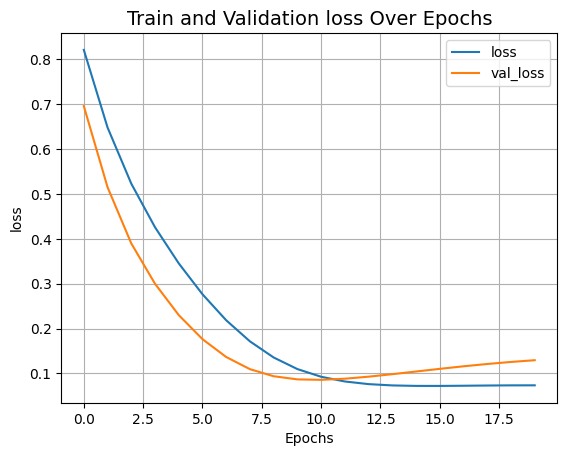

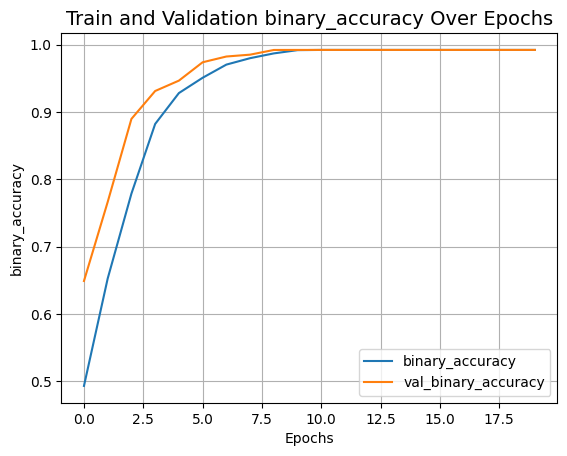

In [47]:
epochs = 20

shallow_mlp_model = make_model()
shallow_mlp_model.compile(
    loss="binary_crossentropy", optimizer="adam", metrics=["binary_accuracy"]
)

history = shallow_mlp_model.fit(
    train_dataset, validation_data=validation_dataset, epochs=epochs
)


def plot_result(item):
    plt.plot(history.history[item], label=item)
    plt.plot(history.history["val_" + item], label="val_" + item)
    plt.xlabel("Epochs")
    plt.ylabel(item)
    plt.title("Train and Validation {} Over Epochs".format(item), fontsize=14)
    plt.legend()
    plt.grid()
    plt.show()


plot_result("loss")
plot_result("binary_accuracy")

### Evaluate the model

In [48]:
_, binary_acc = shallow_mlp_model.evaluate(test_dataset)
print(f"Categorical accuracy on the test set: {round(binary_acc * 100, 2)}%.")

2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step - binary_accuracy: 0.9920 - loss: 0.1432
Categorical accuracy on the test set: 99.2%.


The trained model gives us an evaluation accuracy of ~99%.

In [49]:

# We create a custom Model to override the predict method so
# that it first vectorizes text data
class ModelEndtoEnd(keras.Model):

    def predict(self, inputs):
        indices = text_vectorizer(inputs)
        return super().predict(indices)


def get_inference_model(model):
    inputs = shallow_mlp_model.inputs
    outputs = shallow_mlp_model.outputs
    end_to_end_model = ModelEndtoEnd(inputs, outputs, name="end_to_end_model")
    end_to_end_model.compile(
        optimizer="adam", loss="binary_crossentropy", metrics=["accuracy"]
    )
    return end_to_end_model


model_for_inference = get_inference_model(shallow_mlp_model)

# Create a small dataset just for demonstrating inference.
inference_dataset = make_dataset(test_df.sample(2), is_train=False)
text_batch, label_batch = next(iter(inference_dataset))
predicted_probabilities = model_for_inference.predict(text_batch)


# Perform inference.
for i, text in enumerate(text_batch[:5]):
    label = label_batch[i].numpy()[None, ...]
    print(f"Abstract: {text}")
    print(f"Label(s): {invert_multi_hot(label[0])}")
    predicted_proba = [proba for proba in predicted_probabilities[i]]
    top_3_labels = [
        x
        for _, x in sorted(
            zip(predicted_probabilities[i], lookup.get_vocabulary()),
            key=lambda pair: pair[0],
            reverse=True,
        )
    ][:3]
    print(f"Predicted Label(s): ({', '.join([label for label in top_3_labels])})")
    print(" ")

(2,)
2
2
2
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step
Abstract: b'\xd0\x93\xd0\xbe\xd1\x84\xd1\x80\xd0\xbe\xd0\xbb\xd0\xb8\xd1\x81\xd1\x82 \xd0\xb4\xd0\xbb\xd0\xb8\xd0\xbd\xd0\xb0 80 \xd1\x81\xd0\xbc, \xd1\x88\xd0\xb8\xd1\x80\xd0\xb8\xd0\xbd\xd0\xb0 40 \xd1\x81\xd0\xbc, \xd0\xb2\xd1\x8b\xd1\x81\xd0\xbe\xd1\x82\xd0\xb0 0.35 \xd1\x81\xd0\xbc.'
Label(s): ['[UNK]']
Predicted Label(s): (Держатель.для.штанги, Ремкомплект.аппарата.химчистки.для.авто, Вертушка)
 
Abstract: b'(P Y V W) \xd0\x90\xd0\xb2\xd1\x82\xd0\xbe\xd0\xbc\xd0\xbe\xd0\xb1\xd0\xb8\xd0\xbb\xd1\x8c\xd0\xbd\xd1\x8b\xd0\xb9 \xd0\xa0\xd0\xb5\xd0\xb3\xd0\xb8\xd1\x81\xd1\x82\xd1\x80\xd0\xb0\xd1\x82\xd0\xbe\xd1\x80 HD-\xd0\x92\xd0\xb8\xd0\xb4\xd0\xb5\xd0\xbe\xd1\x80\xd0\xb5\xd0\xb3\xd0\xb8\xd1\x81\xd1\x82\xd1\x80\xd0\xb0\xd1\x82\xd0\xbe\xd1\x80 \xd0\x9f\xd0\xbb\xd0\xb0\xd1\x81\xd1\x82\xd0\xb8\xd0\xba\xd0\xbe\xd0\xb2\xd1\x8b\xd0\xb5 \xd0\x90\xd0\xb2\xd1\x82\xd0\xbe\xd0\xbc\xd0\xbe\xd0\xb1\xd0\xb8\xd0\xbb\xd1\x8c\xd0\xbd\xd1\x8b\xd0\xb5 \xd